In [1]:
import numpy as np

from dataclasses import dataclass
from typing import List
from abc import abstractmethod

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
from tqdm import tqdm

from utils import *
from toolz import curry
from scipy.stats import beta

In [2]:
@curry
def policy_visualizer_bernoulli(choices, rewards, bandit_list, prior, i):    
    number_bandits = len(bandit_list)
    total_iteraction = len(choices)
    
    choices = choices[:i]
    rewards = rewards[:i]
    ones = np.where(rewards==1)
    zeros = np.where(rewards==0)
    colors = np.array(list(map(bandit_to_color, choices)))
    
    ax = fig.add_subplot(gs[0, :])
    ax.clear()
    plt.xlim(-1, total_iteraction)
    plt.ylim(-0.4, number_bandits - 0.6)
    ax.scatter(np.arange(choices.shape[0])[ones], choices[ones], c= colors[ones])
    ax.scatter(np.arange(choices.shape[0])[zeros], choices[zeros], edgecolors= colors[zeros], c='w')
    
    for t in range(number_bandits):
        ax = fig.add_subplot(gs[1, t])
        ax.clear()
        ax.vlines(bandit_list[t].theta, 0, 8, colors='black',alpha = 0.3)
        ax.set_xlim(-0.02, 1.02)
        ax.set_ylim(-0.1, 8.1)
        ax.vlines(np.mean(rewards[np.where(choices==t)]),0,8, colors= bandit_to_color(t))
        if prior:
            x = np.linspace(0,1)
            a = prior[0] + sum(np.array(rewards)[np.where(np.array(choices)==t)])
            b= prior[1] + sum(map(lambda x: 1-x, np.array(rewards)[np.where(np.array(choices)==t)]))
            ax.plot(x, beta.pdf(x, a, b), c= bandit_to_color(t), lw=3, alpha=0.6)

# Journal Club - Experian DataLab Latin America (Carlo - 25/02/2022)

# Multiarmed Bandits

## Formulação clássica (Motivando o problema com bandidos Bernoulli):

Suponha que você entre em um cassino e resolva jogar nas $K$ máquinas de caça-níqueis disponíveis. Assuma que o custo para jogar em cada uma e a recompensa por vencer nelas sejam iguais. Como o resultado é sucesso (você ganha) ou fracasso (você perde), a distribuição que determina se você vai ganhar ou não em uma máquina $k$ ($1\leq k \leq K$) é $\textrm{Ber}(\theta_k)$, com $\theta_k \in [0,1]$ constante no tempo.

<img src="bandido.jpg">

**Você, apostador, se depara com as máquinas sem saber qual é a que te dá mais chance de vencer (ou seja, você não conhece os parâmetros $\theta_k$).**

## Porque o problema é interessante?

### Vários contextos de experimentação podem ser vistos como problemas de multi-armed bandits:
- Escolha de medicação para pacientes doentes visando cura;
- Escolha de abordagens de marketing visando cliques;
- Precificação de produtos visando contratação/engajamento (quão cara meus clientes estão dispostos a pagar pelo serviço?);
- Quando saímos do mundo 0-1, podemos olhar também qual foi o resultado financeiro de ter oferecido um determinado plano pra um cliente... etc etc.
    
    
### Um Processo de Decisão de Markov simplificado ("toy model" de aprendizado por reforço):
- Você consegue formular o problema como sendo o problema de um único ambiente (enquanto não falamos de contexto), em que você tem um conjunto finito de ações e, escolhendo uma dessas ações, a sua interação com o ambiente acaba e você tem o seu resultado final.


### Ótimo exemplo para dinâmica de "exploitation vs exploration":
- Para encontrar a melhor máquina ao mesmo tempo que não temos prejuízo de jogar em máquinas ruins, devemos balancear nosso apetite pela exploração das máquinas que se mostraram melhores no passado e pela experimentação de máquinas que possivelmente podem se provar melhores.

> **Exploration** involves activities such as **search**, variation, **risk taking**, experimentation, discovery, and innovation. **Exploitation** involves activities such as **refinement**, **efficiency**, selection, implementation, and execution.

<img src="sujinho.jpg" width="700">

<center>Hambúrguer de shitake com catupiry e salmão vs um tradicional de bacon.</center>


## Modelando os bandidos em Python

In [3]:
@dataclass
class Bandit:
    theta: float
        
    @abstractmethod
    def pull(self, contexto=None):
        ...


In [4]:
@dataclass
class BernoulliBandit(Bandit):

    def __post_init__(self):
        if self.theta>1 or self.theta<0:
            raise ValueError('theta must be between 0 and 1.')
    
    def pull(self, contexto=None):
        return np.random.binomial(1, p = self.theta)

In [5]:
bandit = BernoulliBandit(0.9)

In [6]:
bandit.pull()

1

In [7]:
sum(bandit.pull() for i in range(10000))

8964

## Como escolher como jogar nos bandidos?

### Política Aleatória (fase de full exploration + fase de full exploitation):

Claramente uma política completamente aleatória não parece uma boa opção por estarmos usando apenas exploration nesse caso, mas uma pequena variação dela pode ser uma opção.

Jogando aleatoriamente entre todas as máquinas por um período específico, conseguimos calcular, utilizando um estimador (por exemplo o de máxima verossimelhaça), o parâmetro $\theta_k$ das Bernoullis!

A política segue a regra dada como:
* Em um primeiro momento, esse algoritmo faz apenas a exploração:
    * Sorteia-se um $k \in [1, K] \cap \mathbb{Z}$ uniformemente.
    * Joga-se na máquina $k$.


* Após esse primeiro momento, estima-se os parâmetros

$$\hat{\theta}_k = \frac{\textrm{(número de vezes que vencemos jogando em }k)}{(\textrm{número de jogadas totais em }k)},$$

  e decide-se jogar na máquina com melhor $\hat{\theta}_k$.

In [8]:
@dataclass
class RandomPolicy:
    prop_explore: float 
    
    def __post_init__(self):
        if self.prop_explore>1 or self.prop_explore<0:
            raise ValueError('prop_explore must be between 0 and 1.')
    
    def play(self, bandit_list, n):
        number_bandits = len(bandit_list)
        choices = []
        rewards = []
        exploration_time = int(n*self.prop_explore)
        for i in range(exploration_time):
            choice = np.random.choice(range(number_bandits))
            choices.append(choice)
            rewards.append(bandit_list[choice].pull(i))
        for i in range(n-exploration_time):
            choice = np.argmax([np.mean(np.array(rewards)[np.where(np.array(choices)==bandit)]) for bandit in range(number_bandits)])
            choices.append(choice)
            rewards.append(bandit_list[choice].pull(i))
        return np.array(choices), np.array(rewards)

In [9]:
bandit_list = [BernoulliBandit(theta) for theta in [0.3, 0.15, 0.4, 0.35]]

random_policy = RandomPolicy(0.5)
choices_random, rewards_random = random_policy.play(bandit_list, 100)

<IPython.core.display.Javascript object>


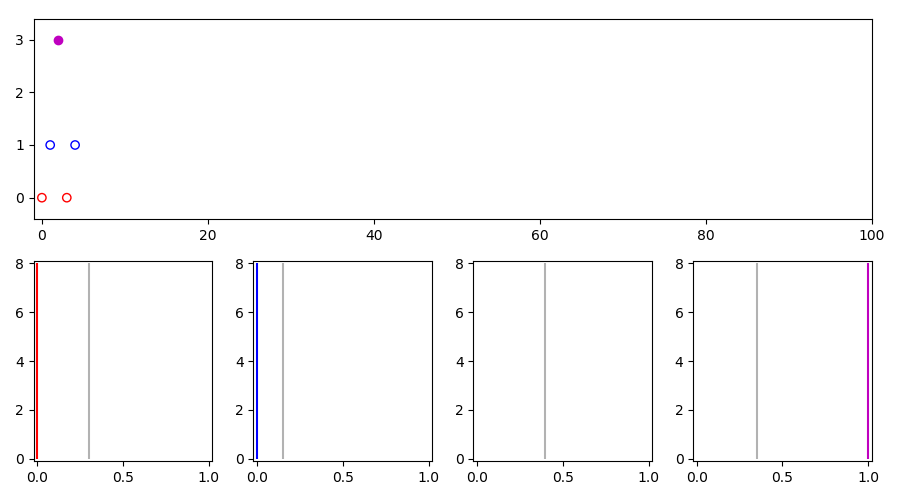

In [10]:
fig = plt.figure(tight_layout=True, figsize=(9,5))
gs = gridspec.GridSpec(2, len(bandit_list))

animation = FuncAnimation(fig, func=policy_visualizer_bernoulli(choices_random, rewards_random, bandit_list, False),
                          frames=range(100), interval=150, repeat=True)

## Como avaliar o nosso algoritmo?

### Acúmulo de arrependimento

No nosso cenário controlado, pode ser interessante calcular o arrependimento da rodada $n$ como $\theta_\textrm{best} - \theta^n$, em que $\theta_\textrm{best}$ é o parâmetro da melhor máquina e $\theta^n$ é o parâmetro da máquina escolhida na rodada $n$.

Dado um tempo de treinamento $N$, podemos calcular o arrependimento acumulado como

$$ \sum_{n=1}^N  \theta_\textrm{best} - \theta ^n. $$

Essa é uma das métricas de avaliação de modelos para esse tipo de problema.

In [11]:
from itertools import accumulate

def regret_curve(choices, bandit_list):
    best_bandit_theta = np.max([bandido.theta for bandido in bandit_list])
    return list(accumulate(best_bandit_theta - bandit_list[choice].theta for choice in choices))

<IPython.core.display.Javascript object>


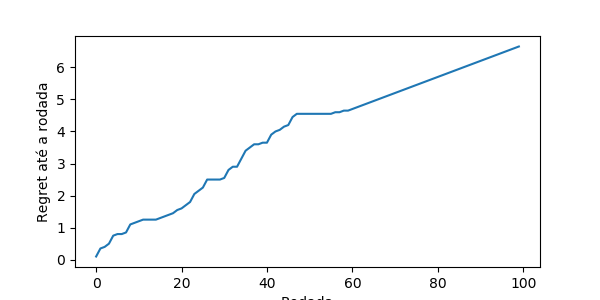

In [12]:
fig = plt.figure(figsize=(6,3))
plt.plot(range(len(choices_random)),regret_curve(choices_random, bandit_list))
plt.xlabel('Rodada')
plt.ylabel('Regret até a rodada')
plt.show()

### Acúmulo de recompensa

Uma outra forma de avaliar nossas políticas pode ser olhando quem está ganhando mais conforme joga.

In [13]:
def reward_curve(rewards):
    return list(accumulate(rewards))

<IPython.core.display.Javascript object>


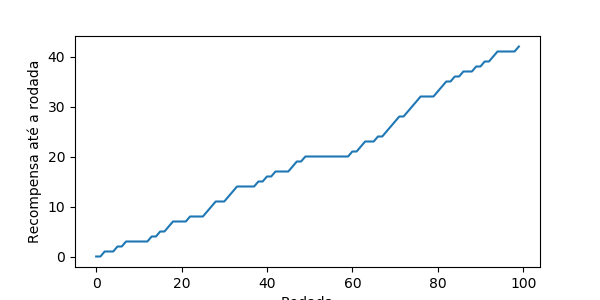

In [14]:
fig = plt.figure(figsize=(6,3))
plt.plot(range(len(choices_random)),reward_curve(rewards_random))
plt.xlabel('Rodada')
plt.ylabel('Recompensa até a rodada')
plt.show()

### Soluções subótimas

Estavamos explorando um cenário muito fácil com grande diferença no valor dos $\theta_k$. Por isso, um tempo de exploração qualquer era suficiente para achar bem uma estimativa dos parâmetros. Se não explorarmos o suficiente, podemos ficar presos em soluções subótimas.

In [15]:
random_policy.prop_explore = 0.2
choices_random, rewards_random = random_policy.play(bandit_list, 50)

<IPython.core.display.Javascript object>


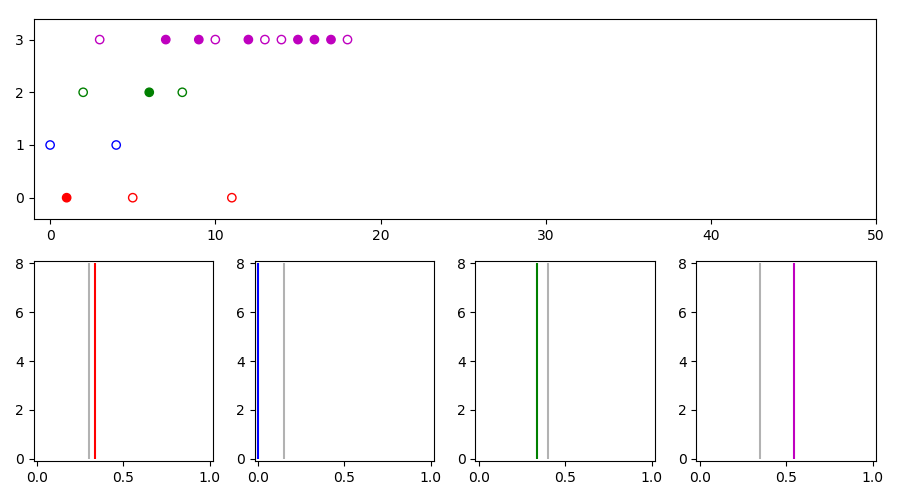

In [16]:
fig = plt.figure(tight_layout=True, figsize=(9,5))
gs = gridspec.GridSpec(2, len(bandit_list))

animation = FuncAnimation(fig, func=policy_visualizer_bernoulli(choices_random, rewards_random, bandit_list, False),
                          frames=range(100), interval=150, repeat=True)

Pela Lei Forte dos Grandes Números (para Bernoullis), os parâmetros $\hat{\theta}_k$ convergem quase-certamente para o verdadeiro $\theta_k$ quando o $({\textrm{número de jogadas totais em }k})$ cresce, mas isso pode demorar muito mais que o desejado.

Quando o custo de cada jogada é muito baixo, essa estratégia pode ser útil. Por outro lado, parando de jogar "cedo demais", podemos estimar de forma errada os valores de $\theta_k$ e ficar estagnado em uma estratégia subótima.

No geral, buscamos políticas que durante a fase de experimentação já aprendam com os acertos e erros das jogadas passadas.

### Estratégia $\varepsilon$-greedy

Essa é a primeira estratégia que tenta equilibrar ao mesmo tempo a exploration e a exploitation. Sem etapas separadas, como anteriormente. 

A política segue a regra dada como:
* Defina $\hat{\theta}_k(0) = 0.5$ para $1\leq k \leq K$.
* No início da rodada $n$ sorteamos um número de uma distribuição $\textrm{Ber}(\varepsilon)$. Se o número sorteado for 1, então $ k = \arg \max \hat{\theta}_t(n)$. Se o número sorteado for zero então sorteia-se um $k \in [1, K] \cap \mathbb{Z}$ uniformemente.
* Joga-se na máquina $k$.

In [17]:
@dataclass
class EpsilonGreedyPolicy:
    epsilon: float 
    
    def __post_init__(self):
        if self.epsilon>1 or self.epsilon<0:
            raise ValueError('prop_explore must be between 0 and 1.')
    
    def get_epsilon(self, i, n):
        return self.epsilon
    
    def play(self, bandit_list, n):
        number_bandits = len(bandit_list)
        choices = []
        rewards = []
        for i in range(n):
            if np.random.binomial(1, 1- self.get_epsilon(i, n)) == 0:
                choice = np.random.choice(range(number_bandits))
            else:
                choice = np.argmax([np.mean(np.array(rewards)[np.where(np.array(choices)==bandit)]) 
                                    if np.array(rewards)[np.where(np.array(choices)==bandit)].shape[0]>0 
                                    else 0.5 for bandit in range(number_bandits) ])
            choices.append(choice)
            rewards.append(bandit_list[choice].pull(i))
        return np.array(choices), np.array(rewards)

In [18]:
greedy_policy = EpsilonGreedyPolicy(0.5)
choices_greedy, rewards_greedy = greedy_policy.play(bandit_list, 100)

<IPython.core.display.Javascript object>


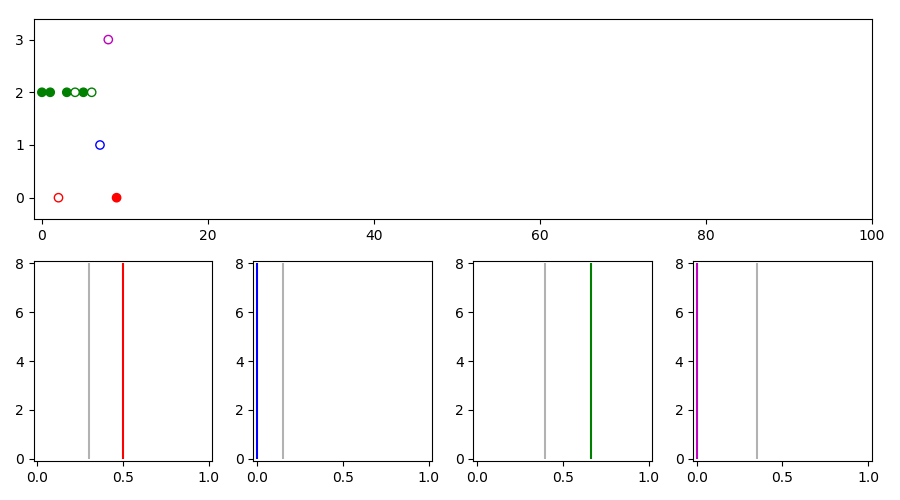

In [19]:
fig = plt.figure(tight_layout=True, figsize=(9,5))
gs = gridspec.GridSpec(2, len(bandit_list))

animation = FuncAnimation(fig, func=policy_visualizer_bernoulli(choices_greedy, rewards_greedy, bandit_list, False),
                          frames=range(100), interval=150, repeat=True)

### Estratégia $\varepsilon$-decreasing

A ideia aqui é adaptar o tamanho do $\varepsilon$ de acordo com o momento da exploração. Neste caso, a probabilidade de escolher uma máquina ao acaso na jogada $n$ é dada por uma função decrescente $\varepsilon(n)$ limitada inferiormente por 0.
Um exemplo poderia ser da forma:

$$ \varepsilon(n) = \varepsilon_0 \left( 1 - \frac{n}{\textrm{tempo total de treinamento}} \right).$$

In [20]:
class EpsilonDecreasingPolicy(EpsilonGreedyPolicy):
    def get_epsilon(self, i, n):
        return self.epsilon*(1-i/n)

In [21]:
greedy_policy = EpsilonDecreasingPolicy(0.5)
choices_greedy, rewards_greedy = greedy_policy.play(bandit_list, 100)

### Abordagem Bayesiana

Podemos interpretar os parâmetros $\theta_k$ das Bernoulli de forma Bayesiana, encarando eles como variáveis aleatórias com distribuições. No caso, uma prior conjugada útil é a $\textrm{Beta}(\alpha, \beta)$, em que $\alpha=\beta=1$ nos da uma prior uniforme no espaço paramétrico $(0,1)$.

<IPython.core.display.Javascript object>


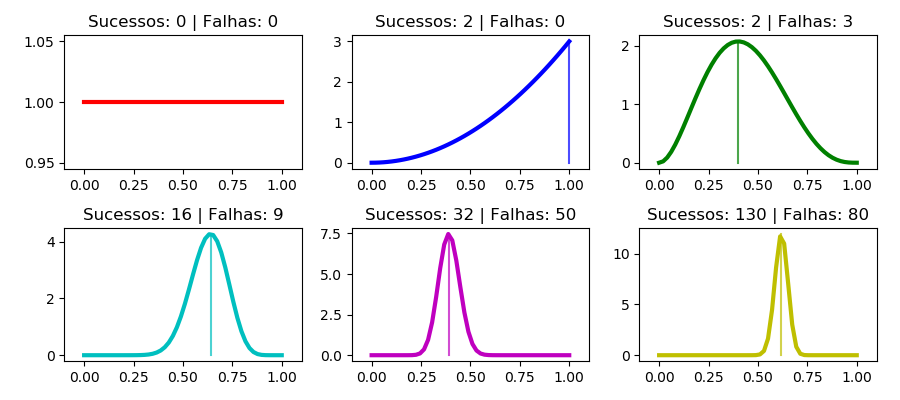

In [22]:
exemplos_beta()

### Estratégia de Thompson Sampling

A política segue a regra dada como:

* No início da rodada $n$, para cada máquina $k$, $1\leq k \leq K$, sorteamos um número $\theta_k^\dagger$ de uma distribuição 

$$\textrm{Beta}(\alpha+(\textrm{(número de vezes que vencemos jogando em }k \textrm{ até a rodada }n),$$

$$\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\beta +(\textrm{(número de vezes que perdemos jogando em }k \textrm{ até a rodada }n))$$

* Escolha o valor de $t$ que tem melhor parâmetro da Bernoulli estimado $\theta_t^\dagger$, isto é,

$$ t =  {\arg\max}_{1\leq k \leq K} \,\,\,\theta_k^\dagger(n),$$

* Joga-se na máquina $t$.

In [23]:
@dataclass
class TSBernoulliBetaPolicy:
    prior_alpha: float = 1
    prior_beta: float = 1
    
    def __post_init__(self):
        if self.prior_alpha<0 or self.prior_beta<0:
            raise ValueError('prior_beta and prior_alpha must be greater than 0.')
    
    def play(self, bandit_list, n):
        number_bandits = len(bandit_list)
        choices = []
        rewards = []
        for i in range(n):
            choice = np.argmax([np.random.beta(self.prior_alpha +
                                               sum(np.array(rewards)[np.where(np.array(choices)==bandit)]),
                                               self.prior_beta + 
                                               sum(map(lambda x: 1-x, np.array(rewards)[np.where(np.array(choices)==bandit)]))) 
                                for bandit in range(number_bandits)])
            choices.append(choice)
            rewards.append(bandit_list[choice].pull(i))
        return np.array(choices), np.array(rewards)

In [24]:
ts_policy = TSBernoulliBetaPolicy()
choices_ts, rewards_ts = ts_policy.play(bandit_list, 100)

<IPython.core.display.Javascript object>


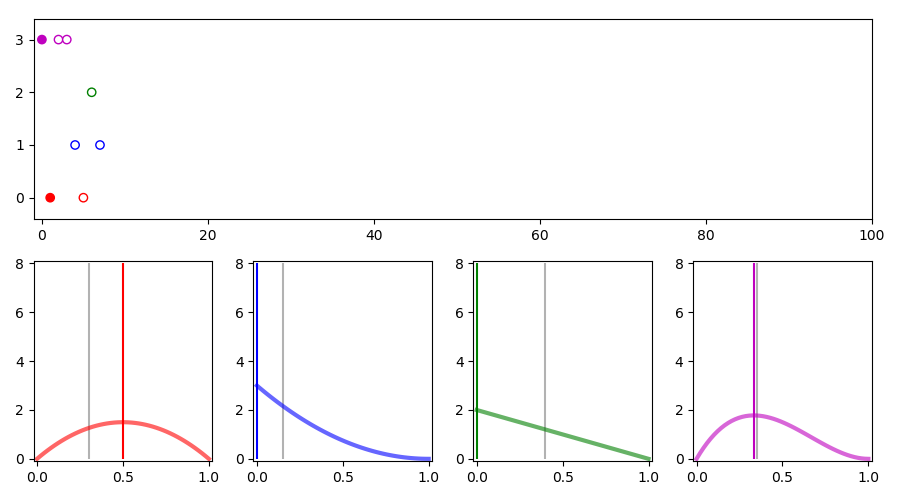

In [25]:
fig = plt.figure(tight_layout=True, figsize=(9,5))
gs = gridspec.GridSpec(2, len(bandit_list))

animation = FuncAnimation(fig, func=policy_visualizer_bernoulli(choices_ts, rewards_ts, bandit_list, (1,1)),
                          frames=range(100), interval=150, repeat=True)

### Outra estratégia que merece ser mencionada: Upper Confidence Bound

A política segue a regra dada como:

* Na rodada n, estima-se os parâmetros como

$$\hat{\theta}_k(n) = \frac{\textrm{(número de vezes que vencemos até agora jogando em }k)}{(\textrm{número de jogadas até agora em }k)}.$$

* Jogamos na máquina que maximiza

$$ \arg \max_k \left( \hat{\theta}_k + c\sqrt{\frac{\log(n)}{(\textrm{número de jogadas até agora em }k)}}  \right) ,$$

em que c é um parâmetro de apetite por exploração.

## Comparando as estratégias

In [26]:
policy_list = [TSBernoulliBetaPolicy(), EpsilonDecreasingPolicy(0.5), EpsilonGreedyPolicy(0.2), RandomPolicy(1)]
labels = ['ts', 'eps-dec', 'eps', 'rand']

In [27]:
bandit_list

[BernoulliBandit(theta=0.3),
 BernoulliBandit(theta=0.15),
 BernoulliBandit(theta=0.4),
 BernoulliBandit(theta=0.35)]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:37<00:00, 11.38s/it]


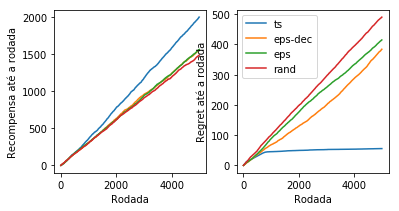

In [28]:
%matplotlib inline
evaluate_policys(policy_list, bandit_list, labels, 5000)

## Bandidos não-Bernoullis

Nem sempre a nossa recompensa é um valor do tipo 0-1. Em muitos casos, a recompensa contínua é melhor representada por alguma outra variável aleatória.

Imagine agora que o bandido nos retorna um valor em dinheiro, por exemplo sendo modelado como uma $\mathcal{N}(\theta_k, 20)$. Queremos rapidamente encontrar qual máquina nos dá mais lucro em média!

In [29]:
@dataclass
class Normal_std20_Bandit(Bandit):
    
    def pull(self, contexto=None):
        return np.random.normal(self.theta, 20)

In [30]:
normal_bandit = Normal_std20_Bandit(50)

In [31]:
normal_bandit.pull()

51.05627164039781

In [32]:
normal_bandit_list = [Normal_std20_Bandit(theta) for theta in [50, 10, 60, 40]]

Uma prior conjugada para esse problema pode ser 

$$ \theta_k \sim \mathcal{N}\left( \mu_0, \sigma_0^2 \right)  ,$$

com posteriori

$$ \mu_k | \textbf{x} \sim \mathcal{N}\left( \frac{1}{\frac{1}{\sigma_{0}^{2}}+\frac{n}{\sigma^{2}}}\left(\frac{\mu_{0}}{\sigma_{0}^{2}}+\frac{\sum_{i=1}^{n} x_{i}}{\sigma^{2}}\right),\left(\frac{1}{\sigma_{0}^{2}}+\frac{n}{\sigma^{2}}\right)^{-1} \right)  ,$$


In [33]:
@dataclass
class TSNormalNormalPolicy:
    prior_mu: float = 1
    prior_sigma: float = 1
    
    def play(self, bandit_list, n):
        number_bandits = len(bandit_list)
        choices = []
        rewards = []
        for i in range(n):
            aux= []
            for bandit in range(number_bandits):
                sum_bandit = sum(np.array(rewards)[np.where(np.array(choices)==bandit)])
                choices_bandit = np.array(rewards)[np.where(np.array(choices)==bandit)].shape[0]
                mu_i = (1/(1/self.prior_sigma + choices_bandit/self.prior_sigma))*(self.prior_mu/self.prior_sigma + sum_bandit/self.prior_sigma)
                sigma2_i = (1/(1/self.prior_sigma + choices_bandit/self.prior_sigma))
                aux.append(np.random.normal(mu_i, np.sqrt(sigma2_i)))
            choice = np.argmax(aux)
            choices.append(choice)
            rewards.append(bandit_list[choice].pull(i))
        return np.array(choices), np.array(rewards)

In [34]:
policy_list = [TSNormalNormalPolicy(), EpsilonDecreasingPolicy(0.5), EpsilonGreedyPolicy(0.2), RandomPolicy(1)]
labels = ['ts', 'eps-dec', 'eps', 'rand']

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  7.07s/it]


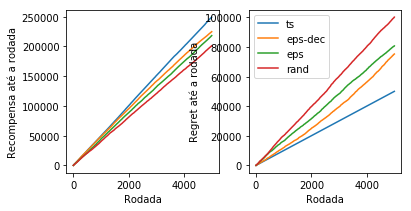

In [35]:
evaluate_policys(policy_list, normal_bandit_list, labels, 5000)

## Drift

Em muitos casos, os parâmetros podem mudar com o tempo (de forma sazonal ou não). É razoável querer incorporar elementos de memória às nossas estratégias, tentando contornar essa variabilidade e olhando apenas para os exemplos passados mais recentes. 

In [46]:
@dataclass
class DriftBernoulliBandit():
    theta_i: float
    theta_f: float
    time: int
    
    def __post_init__(self):
        if self.theta_i>1 or self.theta_i<0 or self.theta_f>1 or self.theta_f<0:
            raise ValueError('theta_i and theta_f must be between 0 and 1.')
        self.thetas = [self.theta_i]*int(self.time/2) + [self.theta_f]*(self.time-int(self.time/2))
    
    def pull(self, i):
        return np.random.binomial(1,self.thetas[i%self.time])

Uma modificação no algoritmo do Thompson Sampling pode ser olhar apenas para as últimas `memory` iterações na hora de calcular as posteriors. No caso do $\varepsilon$-greedy, podíamos olhar apenas para os exemplos mais recentes para estimar o melhor bandido etc.

In [47]:
from collections import deque

@dataclass
class MemoryTSBernoulliBetaPolicy:
    memory : int = 50
    prior_alpha: float = 1
    prior_beta: float = 1
    
    def __post_init__(self):
        if self.prior_alpha<0 or self.prior_beta<0:
            raise ValueError('prior_beta and prior_alpha must be greater than 0.')
    
    def play(self, bandit_list, n):
        number_bandits = len(bandit_list)
        choices, rewards = [], []
        memory_choices, memory_rewards = deque(), deque()
        for i in range(n):
            choice = np.argmax([np.random.beta(self.prior_alpha +
                                               sum(np.array(memory_rewards)[np.where(np.array(memory_choices)==bandit)]),
                                               self.prior_beta + 
                                               sum(map(lambda x: 1-x, np.array(memory_rewards)[np.where(np.array(memory_choices)==bandit)]))) 
                                for bandit in range(number_bandits)])
            choices.append(choice)
            reward = bandit_list[choice].pull(i)
            rewards.append(reward)
            memory_choices.append(choice)
            memory_rewards.append(reward)
            if len(memory_choices)>self.memory:
                memory_choices.popleft()
                memory_rewards.popleft()
        return np.array(choices), np.array(rewards)

In [51]:
policy_list = [TSBernoulliBetaPolicy(), MemoryTSBernoulliBetaPolicy(30), RandomPolicy(0.25),
               RandomPolicy(0.5),  RandomPolicy(0.75)]

In [52]:
drift_bandit_list = [DriftBernoulliBandit(i, j, 500) for i,j in zip([0.1, 0.8],[0.9, 0.2])]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  7.05s/it]


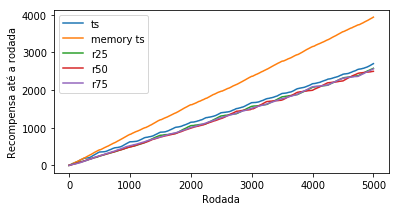

In [53]:
evaluate_policys(policy_list, drift_bandit_list,['ts','memory ts', 'r25', 'r50', 'r75'], 5000, False)

## Contexto

De forma mais geral, a recompensa de um determinado bandido (apesar de aleatória) pode ser diferente dependendo de variáveis externas. Ou seja, existe um conjunto de variáveis $x$ tais que $\theta_k$ dependem delas.

Exemplos:

- Clientes com perfis diferentes reagirão melhor ou pior a determinadas ofertas.
- Pacientes com trajetórias médicas diferentes reagirão de forma diferente ao mesmo tratamento etc.

A mudança temporal pode ser encarada como um tipo específico de mudança de conceito também.

### Tentando prever $\theta_k(x)$

Existem algumas formas de encarar esse problema. Podemos explicitamente tentar calcular $\theta_k(x)$ cada vez que vamos decidir pela próxima escolha. Para isso, precisamos de uma base batch de um experimento anterior randomizado ou algum algoritmo online que nos permita atualizar nossa estimativa de $\theta_k(x)$ (uma vez que estamos em um contexto de desconhecimento).

### Clusterizando $x$

Sabendo de antemão os valores de $x$ que devemos encontrar (não é muito absurdo uma vez que podem ser nossos clientes já, por exemplo), podemos criar clusters de $x$ e encarar cada cluster como um se fosse um bandido "sem contexto".

## Life-time-value estimation

Nem sempre a recompensa da nossa escolha é imediata. Por exemplo, se estamos escolhendo um serviço para ofertar para o cliente, dada a escolha temos dois possíveis caminhos. No primeiro, o cliente não aceita a oferta e não compra, nos dando um resultado de zero reais. No segundo, o cliente aceita, mas o resultado demora possivelmente anos para ser calculado e só então poderemos atualizar nossa política.

Aqui entra a ideia de surrogate models e modelos de previsão de resultado longo. Com algumas variáveis da interação com ele e mais outras varáveis do meu cliente, consigo prever o resultado que terei a longo prazo? Se sim, podemos utilizar isso para atualizar nossa política.

## Uma aplicação não imediata: Prediction with expert advice

Imagine que temos alguns modelos candidatos que queremos avaliar a performance de forma online (isto é, na iteração na prática). Por exemplo um modelo antigo vs um modelo mais novo. Podemos encarar o processo de decisão  de qual modelo utilizar como um problema de multi-armed bandits. Dessa forma

Existe uma diferença importante nesse caso. Se for barato fazer a previsão e calcular a métrica para todos os modelos, não somente o modelo usado pode receber recompensa. Nesse caso, você consegue ter estimativas atualizadas para todos os modelos em todas as iterações e ser bem mais Greedy.

Inclusive, essa é a abordagem que temos implementada no https://riverml.xyz/latest/api/model-selection/GreedyRegressor/.

Em outros casos, seguindo uma abordagem mais online (de atualização do modelo), pode ser enviável atualizar todos em todas as novas iterações. Neste caso, estratégias vistas anteriormente são muito úteis para atualizar apenas os modelos que se demonstraram melhores até aquele momento.

Abaixo temos um exemplo retirado da biblioteca river:

In [56]:
from river import datasets
from river import evaluate
from river import linear_model
from river import metrics
from river import model_selection
from river import optim
from river import preprocessing

models = [
    linear_model.LinearRegression(optimizer=optim.SGD(lr=lr))
    for lr in [0.0001, 0.001, 1e-05, 0.01]
]
dataset = datasets.TrumpApproval()
model = (
    preprocessing.StandardScaler() |
    model_selection.EpsilonGreedyRegressor(
        models,
        epsilon=0.1,
        decay=0.001,
        burn_in=100,
        seed=1
    )
)
metric = metrics.MAE()

ModuleNotFoundError: No module named 'river'

In [ ]:
evaluate.progressive_val_score(dataset, model, metric)


In [ ]:
model['EpsilonGreedyRegressor'].bandit

In [ ]:
model['EpsilonGreedyRegressor'].best_model

Referências:

https://gdmarmerola.github.io/

https://banditalgs.com/

https://tor-lattimore.com/downloads/book/book.pdf

https://riverml.xyz/latest/api/model-selection/EpsilonGreedyRegressor/